In [240]:
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from pydub import AudioSegment
%matplotlib inline
import os

In [162]:
f_path = 'shinmina.wav'
wave, fs = librosa.load(f_path, sr=None)

In [163]:
10 * fs / 1000

441.0

In [257]:
def _get_frame(frame_sample_ms=20, shift_sample_ms=10):
    """
    input: frame_sample_ms(samples of window, ms단위, int)
           shift_sample_ms(samples of shift, ms단위, int)
    todo: frame과 hop_frame의 길이 안의 samples를 계산
    return: frame_len, frame_shift 
            자료형은 int
    """
    frame_len = int(frame_sample_ms*fs/1000) # frame_len = len_sample(ms) 만큼의 samples
    frame_shift = int(shift_sample_ms*fs/1000)
    return frame_len, frame_shift

def _get_rms_zcr(frame_sample_ms=20, shift_sample_ms=10):
    """
    input: frame_sample_ms, shift_sample_ms
    todo: RMS, ZCR 계산 후 벡터라이징
    return: rms, zcr
    """
    # get frame_len, frame_shift
    frame_len, frame_shift = _get_frame(frame_sample_ms, shift_sample_ms)
    # calculate RMS
    rms = librosa.feature.rmse(wave,frame_length=frame_len, hop_length=frame_shift)
    rms = rms[0]
    rms = librosa.util.normalize(rms, axis=0)
    # calculate zero-crossing rate
    zcr = librosa.feature.zero_crossing_rate(wave, frame_length=frame_len, hop_length=frame_shift)
    zcr = zcr[0]
    return rms, zcr
    
def _get_frame_idxs(min_rms=0.1, min_zcr=0.3):
    """
    rms, zcr을 구한 뒤 실행
    todo: rms와 zcr의 기준점을 인풋으로 하여 조건을 충족하는 element의 인덱스를 return.(현재는 임의)
    input: min_rms, min_zcr
    return: frame_idxs
    """
    frame_idxs = np.where((rms>min_rms)|(zcr>min_zcr))[0]
    return frame_idxs

def _getboundaries(frame_idxs, frame_len, frame_shift):
    """
    todo: starttime과 endtime을 구한다.
    input: frame_idxs, frame_len,frame_shift
    return: start_t, end_t (시작시간과 끝시간을 np.array로 리턴한다.)
    """
    start_idxs = [frame_idxs[0]]
    end_idxs = []
    shapeOfIdxs = np.shape(frame_idxs)
    for i in range(shapeOfIdxs[0]-1):
        if (frame_idxs[i+1]-frame_idxs[i]) != 1:
            end_idxs.append(frame_idxs[i])
            start_idxs.append(frame_idxs[i+1])
    end_idxs.append(frame_idxs[-1])
    
    # del the last boundaries if it is both start point and end point
    if end_idxs[-1] == start_idxs[-1]:
        end_idxs.pop()
        start_idxs.pop()
    assert len(start_idxs) == len(end_idxs), "Error! Num of start_idxs doesnt match Num of end_idxs"
    start_idxs = np.array(start_idxs)
    end_idxs = np.array(end_idxs)
    start_t = start_idxs*frame_shift/fs
    end_t=end_idxs*frame_shift/fs
    return start_t, end_t

def _arraytolist(start_t, end_t):
    """
    todo: 시작, 끝, 구간시간, 구간별차이시간을 구해서 리턴한다.
    input: start_t, end_t
    output: [[start, end], 구간시간, 구간별차이시간(gap)]의 리스트
    """
    tolist = list(zip(start_t, end_t))
    info_list = []
    for i in range(len(tolist)):
        elm_minus = tolist[i][1] - tolist[i][0]
        elm_minus = round(elm_minus, 3)
        if i != 0: #이전과의 gap을측정
            gap = tolist[i][0] - tolist[i-1][1]
            gap = round(gap, 3)
        else: # i==0
            gap = -1 # 예외처리
        to_append = [[tolist[i][0], tolist[i][1]], elm_minus, gap]
        info_list.append(to_append)
    return info_list 
            
def endpoint_connect(info_list, prm_len=0.1, prm_gap=0.3):
    """
    todo: 구간길이와, 구간별 gap을 통하여 endpoint를 연결하고
          너무 짧은 구간은 삭제한다.
    input: info_list,  prm_len(구간의 길이), prm_gap(구간별 타임코드의 차이)
    return: confirm_list(모든 처리가 끝난 후의 리스트, info_list와 같은 형식)
    """
    i = 1
    tmp = 0
    new_zip = [] # 간격이 벌어진 구간이 나타날 때 이전 구간을 저장하는 곳
    confirm_list = []
    while i < len(info_list):         
        if info_list[i][2] <= prm_gap: # 간격이 작으면 앞의 것과 연결하기
            info_list[tmp][0][1] = info_list[i][0][1]
            if i == len(info_list)-1:
                new_zip.append(info_list[tmp][0])
        else: # 간격이 충분히 크다면
            new_zip.append(info_list[tmp][0])
            tmp = i # 시작 변경
        i += 1
    for elm in new_zip: # 확정구간중 너무 작은 구간을 제거함
        if elm[1]-elm[0] < prm_len:
            pass
        else:
            confirm_list.append(elm)
    return confirm_list
            
def audioseg(t1, t2, i=0, rms=0):
    """
    todo: t1(sec), t2(sec) 사이를 잘라 지정 디렉토리에 리턴하는 함수
    input: t1, t2
    output: 디렉토리에 파일 생성
    """
    t1 = t1*1000
    t2 = t2*1000
    newAudio = AudioSegment.from_wav(f_path)
    newAudio = newAudio[t1:t2]
    try:
        export_path = 'C:\\Users\\jmlik\\Desktop\\Work\\mywork\\simplevad\\auditok_eg\\'+str(rms)
        mkdir_mina = os.mkdir(export_path)
    except:
        export_path = 'C:\\Users\\jmlik\\Desktop\\Work\\mywork\\simplevad\\auditok_eg\\'+str(rms)
    return newAudio.export(export_path+'\\newmina' +str(i)+ '.wav', format="wav")

def makeWavFile(confirm_list, rms):
    for num in range(len(confirm_list)):
        audioseg(confirm_list[num][0], confirm_list[num][1], num, rms)
    return "Finish"

In [165]:
frame_len, frame_shift = _get_frame()
rms, zcr = _get_rms_zcr()
frame_idxs = _get_frame_idxs(0.1, 0.4)
start_t, end_t = _getboundaries(frame_idxs, frame_len, frame_shift)
info_list = _arraytolist(start_t, end_t)
confirm_list = endpoint_connect(info_list, prm_gap=0.5,prm_len=0.2)

In [166]:
makeWavFile(confirm_list)

'Finish'

In [167]:
frame_len, frame_shif = _get_frame()
rms, zcr = _get_rms_zcr()

In [168]:
frame_idxs_0 = _get_frame_idxs(0,1)

In [169]:
def frameOffRate(now_frame_idxs, pre_frame_idxs):
    now_len = len(now_frame_idxs)
    pre_len = len(pre_frame_idxs)
    offrate = now_len/pre_len
    return offrate

In [170]:
frame_idxs_01 = _get_frame_idxs(0.5, 1)
offRate = frameOffRate(frame_idxs_01, frame_idxs_0)
offRate

0.07807118254879448

In [211]:
x_bar = np.arange(0,1,0.01)
def get_offrate(x_bar):
    """zrc고정"""
    prelen = len(_get_frame_idxs(0, 1))
    nowlen = 0
    y_bar = []
    toreturn = []
    toreturndic = {}
    for i in x_bar:
        nowlen = len(_get_frame_idxs(i, 1))
        offrate = 1 - (nowlen/prelen)
        offrate = round(offrate, 2)
        toreturndic = {"RMS":round(i,3), "Offrate":offrate}
        toreturn.append(toreturndic)
#         y_bar.append(offrate)
        prelen = nowlen
    
    
    return toreturn

In [215]:
rms_and_offrate_dic = get_offrate(x_bar)

In [217]:
# y_axis = get_y_bar(x_bar)
y_axis = []
for i in rms_and_offrate_dic:
    y_axis.append(i["Offrate"])
len(y_axis)

100

'\nx_bar는 rms 0.01단위 수치\ny_axis는 손실률\n'

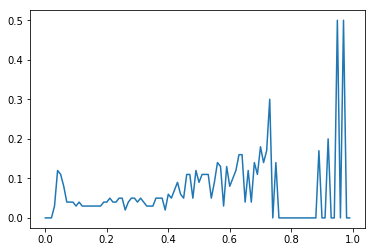

In [218]:
plt.plot(x_bar, y_axis)
"""
x_bar는 rms 0.01단위 수치
y_axis는 손실률
"""

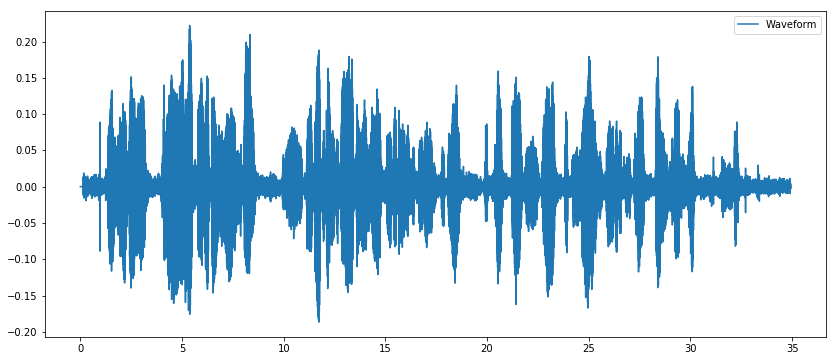

In [183]:
t = np.linspace(0, len(wave)/sr, len(wave))
plt.figure(figsize=(14,6))
plt.plot(t, wave, label="Waveform")
plt.legend(loc="best")

In [219]:
rms_and_offrate_dic

[{'Offrate': 0.0, 'RMS': 0.0},
 {'Offrate': 0.0, 'RMS': 0.01},
 {'Offrate': 0.0, 'RMS': 0.02},
 {'Offrate': 0.03, 'RMS': 0.029999999999999999},
 {'Offrate': 0.12, 'RMS': 0.040000000000000001},
 {'Offrate': 0.11, 'RMS': 0.050000000000000003},
 {'Offrate': 0.08, 'RMS': 0.059999999999999998},
 {'Offrate': 0.04, 'RMS': 0.070000000000000007},
 {'Offrate': 0.04, 'RMS': 0.080000000000000002},
 {'Offrate': 0.04, 'RMS': 0.089999999999999997},
 {'Offrate': 0.03, 'RMS': 0.10000000000000001},
 {'Offrate': 0.04, 'RMS': 0.11},
 {'Offrate': 0.03, 'RMS': 0.12},
 {'Offrate': 0.03, 'RMS': 0.13},
 {'Offrate': 0.03, 'RMS': 0.14000000000000001},
 {'Offrate': 0.03, 'RMS': 0.14999999999999999},
 {'Offrate': 0.03, 'RMS': 0.16},
 {'Offrate': 0.03, 'RMS': 0.17000000000000001},
 {'Offrate': 0.03, 'RMS': 0.17999999999999999},
 {'Offrate': 0.04, 'RMS': 0.19},
 {'Offrate': 0.04, 'RMS': 0.20000000000000001},
 {'Offrate': 0.05, 'RMS': 0.20999999999999999},
 {'Offrate': 0.04, 'RMS': 0.22},
 {'Offrate': 0.04, 'RMS': 0.

In [271]:
"""
dic에 doffrate 추가하기
"""
def get_doffrate(rms_and_offrate_dic):
    x_bar = []
    y_axis = []
    for i in rms_and_offrate_dic:
        x_bar.append(i["RMS"])
        y_axis.append(i["Offrate"])
    dx = x_bar[1] - x_bar[0]
    dorlist = []
    for idx, elm in enumerate(y_axis):
        if idx == 0: # 끝이라면
            dor = 0.0
            dorlist.append(dor)
        else:
            dor = (y_axis[idx] - y_axis[idx-1]) / dx
            dor = round(dor,3)
            dorlist.append(dor)                

    for idx, elm in enumerate(rms_and_offrate_dic):
        elm["dOffrate"] = dorlist[idx]

    """
    float로 바꾸기
    """
    
    for idx, elm in enumerate(rms_and_offrate_dic):
        elm["RMS"] = int(elm["RMS"] * 100) / 100
        elm["dOffrate"] = int(elm["dOffrate"] * 100) / 100
    
    return rms_and_offrate_dic

In [235]:
"""
dor이 3 이상인 밸류만 찾기
"""
check_dor = {}
check_dor_list = []
for idx, elm in enumerate(doffratelist):
    if int(abs(elm["dOffrate"])) >= 3 or idx == 0:
        check_dor = elm
        check_dor_list.append(check_dor)

In [236]:
for i in check_dor_list:
    i["RMS"] = int(i["RMS"] * 100)/100

In [237]:
check_dor_list

[{'Offrate': 0.0, 'RMS': 0.0, 'dOffrate': 0.0},
 {'Offrate': 0.0, 'RMS': 0.02, 'dOffrate': 3.0},
 {'Offrate': 0.03, 'RMS': 0.03, 'dOffrate': 9.0},
 {'Offrate': 0.11, 'RMS': 0.05, 'dOffrate': -3.0},
 {'Offrate': 0.08, 'RMS': 0.06, 'dOffrate': -4.0},
 {'Offrate': 0.05, 'RMS': 0.25, 'dOffrate': -3.0},
 {'Offrate': 0.05, 'RMS': 0.38, 'dOffrate': -3.0},
 {'Offrate': 0.02, 'RMS': 0.39, 'dOffrate': 4.0},
 {'Offrate': 0.09, 'RMS': 0.43, 'dOffrate': -3.0},
 {'Offrate': 0.05, 'RMS': 0.45, 'dOffrate': 6.0},
 {'Offrate': 0.11, 'RMS': 0.47, 'dOffrate': -6.0},
 {'Offrate': 0.05, 'RMS': 0.48, 'dOffrate': 7.0},
 {'Offrate': 0.12, 'RMS': 0.49, 'dOffrate': -3.0},
 {'Offrate': 0.11, 'RMS': 0.53, 'dOffrate': -6.0},
 {'Offrate': 0.05, 'RMS': 0.54, 'dOffrate': 4.0},
 {'Offrate': 0.09, 'RMS': 0.55, 'dOffrate': 5.0},
 {'Offrate': 0.13, 'RMS': 0.56, 'dOffrate': -10.0},
 {'Offrate': 0.03, 'RMS': 0.56, 'dOffrate': 10.0},
 {'Offrate': 0.13, 'RMS': 0.59, 'dOffrate': -5.0},
 {'Offrate': 0.12, 'RMS': 0.62, 'dOffrate

In [238]:
rms_list = []
for i in check_dor_list:
    rms_list.append(i["RMS"])

In [259]:
frame_len, frame_shift = _get_frame()
rms, zcr = _get_rms_zcr()
for i in rms_list:
    frame_idxs = _get_frame_idxs(i, 1)
    start_t, end_t = _getboundaries(frame_idxs, frame_len, frame_shift)
    info_list = _arraytolist(start_t, end_t)
    confirm_list = endpoint_connect(info_list, prm_gap=0.0,prm_len=0.0)
    makeWavFile(confirm_list=confirm_list, rms=i)

In [261]:
frame_len, frame_shift = _get_frame()
rms, zcr = _get_rms_zcr()
i = rms_list[3]
frame_idxs = _get_frame_idxs(i, 1)
start_t, end_t = _getboundaries(frame_idxs, frame_len, frame_shift)
info_list = _arraytolist(start_t, end_t)
# confirm_list = endpoint_connect(info_list, prm_gap=0.0,prm_len=0.0)
# makeWavFile(confirm_list=confirm_list, rms=i)
info_list

[[[0.080000000000000002, 0.089999999999999997], 0.01, -1],
 [[0.28999999999999998, 0.28999999999999998], 0.0, 0.20000000000000001],
 [[0.34999999999999998, 0.35999999999999999], 0.01, 0.059999999999999998],
 [[0.42999999999999999, 0.44], 0.01, 0.070000000000000007],
 [[0.47999999999999998, 0.48999999999999999], 0.01, 0.040000000000000001],
 [[0.62, 0.63], 0.01, 0.13],
 [[0.65000000000000002, 1.71], 1.0600000000000001, 0.02],
 [[1.8400000000000001, 1.8400000000000001], 0.0, 0.13],
 [[1.99, 4.3499999999999996], 2.3599999999999999, 0.14999999999999999],
 [[4.3899999999999997, 4.3899999999999997], 0.0, 0.040000000000000001],
 [[4.4699999999999998, 4.4800000000000004], 0.01, 0.080000000000000002],
 [[4.5599999999999996, 4.5599999999999996], 0.0, 0.080000000000000002],
 [[4.6500000000000004, 4.6799999999999997],
  0.029999999999999999,
  0.089999999999999997],
 [[4.7400000000000002, 4.75], 0.01, 0.059999999999999998],
 [[4.9699999999999998, 5.4699999999999998], 0.5, 0.22],
 [[5.5199999999999

In [262]:
x = np.arange(0,1,0.03)

In [278]:
dic3 = get_offrate(x_bar=x)
total_list = get_doffrate(dic3)
total_list

[{'Offrate': 0.0, 'RMS': 0.0, 'dOffrate': 0.0},
 {'Offrate': 0.04, 'RMS': 0.03, 'dOffrate': 1.33},
 {'Offrate': 0.28, 'RMS': 0.06, 'dOffrate': 8.0},
 {'Offrate': 0.11, 'RMS': 0.09, 'dOffrate': -5.66},
 {'Offrate': 0.1, 'RMS': 0.12, 'dOffrate': -0.33},
 {'Offrate': 0.09, 'RMS': 0.15, 'dOffrate': -0.33},
 {'Offrate': 0.08, 'RMS': 0.18, 'dOffrate': -0.33},
 {'Offrate': 0.12, 'RMS': 0.21, 'dOffrate': 1.33},
 {'Offrate': 0.12, 'RMS': 0.24, 'dOffrate': 0.0},
 {'Offrate': 0.1, 'RMS': 0.27, 'dOffrate': -0.66},
 {'Offrate': 0.13, 'RMS': 0.3, 'dOffrate': 1.0},
 {'Offrate': 0.12, 'RMS': 0.33, 'dOffrate': -0.33},
 {'Offrate': 0.11, 'RMS': 0.36, 'dOffrate': -0.33},
 {'Offrate': 0.12, 'RMS': 0.39, 'dOffrate': 0.33},
 {'Offrate': 0.17, 'RMS': 0.42, 'dOffrate': 1.66},
 {'Offrate': 0.19, 'RMS': 0.45, 'dOffrate': 0.66},
 {'Offrate': 0.25, 'RMS': 0.48, 'dOffrate': 2.0},
 {'Offrate': 0.29, 'RMS': 0.51, 'dOffrate': 1.33},
 {'Offrate': 0.25, 'RMS': 0.54, 'dOffrate': -1.33},
 {'Offrate': 0.32, 'RMS': 0.56, '

In [274]:
dic3
total_list = get_doffrate(dic3)
rms_list = []
offrate_list = []
doffrate_list = []
for i in total_list:
    rms_list.append(i["RMS"])
    offrate_list.append(i["Offrate"])
    doffrate_list.append(i['dOffrate'])

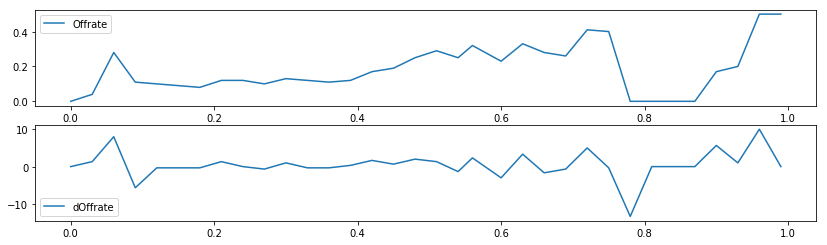

In [279]:
plt.figure(figsize=(14,6))
plt.subplot(3,1,1)
plt.plot(rms_list, offrate_list, label="Offrate")
plt.legend(loc="best")

plt.subplot(3,1,2)
plt.plot(rms_list, doffrate_list, label="dOffrate")
plt.legend(loc='best')

plt.show()

In [289]:
te = tuple(offrate_list)
offrate_array = np.asarray(te)
te = tuple(doffrate_list)
doffrate_array = np.asarray(te)

offrate_mean = np.mean(offrate_array)
doffrate_mean = np.mean(doffrate_array)
offrate_std = np.std(offrate_array)
doffrate_std = np.std(doffrate_array)

In [299]:
total_list

[{'Offrate': 0.0, 'RMS': 0.0, 'dOffrate': 0.0},
 {'Offrate': 0.04, 'RMS': 0.03, 'dOffrate': 1.33},
 {'Offrate': 0.28, 'RMS': 0.06, 'dOffrate': 8.0},
 {'Offrate': 0.11, 'RMS': 0.09, 'dOffrate': -5.66},
 {'Offrate': 0.1, 'RMS': 0.12, 'dOffrate': -0.33},
 {'Offrate': 0.09, 'RMS': 0.15, 'dOffrate': -0.33},
 {'Offrate': 0.08, 'RMS': 0.18, 'dOffrate': -0.33},
 {'Offrate': 0.12, 'RMS': 0.21, 'dOffrate': 1.33},
 {'Offrate': 0.12, 'RMS': 0.24, 'dOffrate': 0.0},
 {'Offrate': 0.1, 'RMS': 0.27, 'dOffrate': -0.66},
 {'Offrate': 0.13, 'RMS': 0.3, 'dOffrate': 1.0},
 {'Offrate': 0.12, 'RMS': 0.33, 'dOffrate': -0.33},
 {'Offrate': 0.11, 'RMS': 0.36, 'dOffrate': -0.33},
 {'Offrate': 0.12, 'RMS': 0.39, 'dOffrate': 0.33},
 {'Offrate': 0.17, 'RMS': 0.42, 'dOffrate': 1.66},
 {'Offrate': 0.19, 'RMS': 0.45, 'dOffrate': 0.66},
 {'Offrate': 0.25, 'RMS': 0.48, 'dOffrate': 2.0},
 {'Offrate': 0.29, 'RMS': 0.51, 'dOffrate': 1.33},
 {'Offrate': 0.25, 'RMS': 0.54, 'dOffrate': -1.33},
 {'Offrate': 0.32, 'RMS': 0.56, '

Vocal Separation

In [300]:
f_path = 'shinmina.wav'

In [301]:
from __future__ import print_function

In [302]:
y, sr = librosa.load(f_path)

S_full, phase = librosa.magphase(librosa.stft(y))

In [308]:
S_filter = librosa.decompose.nn_filter(S_full,
                                      aggregate=np.median,
                                      metric='cosine',
                                      width=int(librosa.time_to_frames(2,sr=sr)))

In [310]:
S_filter = np.minimum(S_full, S_filter)

In [311]:
margin_i, margin_v = 2, 10
power = 2
mask_i = librosa.util.softmask(S_filter,
                              margin_i*(S_full-S_filter),
                              power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                              margin_v * S_filter,
                              power=power)

S_foreground = mask_v * S_full
S_background = mask_i * S_full